In [2]:
### 这个文件和automixmodel是一样的，只是为了测试交叉验证的结果和
# predictisample的结果是否一致，有可能是predictisample的结果没有经过标准化。

# 经过实验证明predictinsample的结果确实没有标准化

import os

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MAE, MSE
from neuralforecast.losses.numpy import mae, mse

# from datasetsforecast.long_horizon import LongHorizon, LongHorizonInfo
from datasetsforecast.long_horizon2 import LongHorizon2, LongHorizon2Info

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)


input_size = 512
horizon = 720
dataset = "Weather"
epochs = 100

Y_df = LongHorizon2.load(directory="./data/", group=dataset)
Y_df["ds"] = pd.to_datetime(Y_df["ds"])
n_time = LongHorizon2Info[dataset].n_time
freq = LongHorizon2Info[dataset].freq
val_size = LongHorizon2Info[dataset].val_size
test_size = LongHorizon2Info[dataset].test_size
Y_df.drop(columns=["index"], inplace=True)
Y_df


,ds,unique_id,y
0,2020-01-01 00:10:00,p (mbar),2.135536
1,2020-01-01 00:20:00,p (mbar),2.120703
2,2020-01-01 00:30:00,p (mbar),2.109293
3,2020-01-01 00:40:00,p (mbar),2.107011
4,2020-01-01 00:50:00,p (mbar),2.103588
...,...,...,...
1106590,2020-12-31 23:20:00,OT,0.055817
1106591,2020-12-31 23:30:00,OT,0.074188
1106592,2020-12-31 23:40:00,OT,0.061941
1106593,2020-12-31 23:50:00,OT,0.058322


In [4]:


nhits = NHITS(
        h = horizon,
        input_size = input_size,
        stack_types = ["identity", "identity", "identity"],  # ?
        n_blocks = [1, 2, 3],
        mlp_units = 1 * [[512, 512]],
        n_pool_kernel_size = [2, 2, 1],
        n_freq_downsample = [4, 2, 1],
        pooling_mode = "MaxPool1d",
        interpolation_mode = "linear",
        dropout_prob_theta=0.2,
        loss=MAE(),
        valid_loss=MAE(),
        max_steps = epochs,
        learning_rate = 1e-3,
        num_lr_decays = -1,
        early_stop_patience_steps = 3,
        val_check_steps = 100,
        batch_size = 32,
        valid_batch_size = None,
        windows_batch_size = 1024,  # 还是没搞懂
        inference_windows_batch_size = 1024,
        step_size = 1,
        scaler_type = "identity",
        random_seed = 1,
        num_workers_loader = 0, # 取决于 cpu 数量
        stat_exog_list=None,
        hist_exog_list=None,
        futr_exog_list=None,
        exclude_insample_y=False,
        drop_last_loader = False,
)

nf = NeuralForecast(models=[nhits], freq=freq)
nf.fit(df=Y_df, val_size=val_size)

Global seed set to 1


32-true


Sanity Checking: 0it [00:00, ?it/s]

nhits的参数量： 5904372


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [5]:
fitted_model = nf.models[0]
Y_hat_df = nf.predict_insample(step_size=horizon)
Y_hat_df

2021-01-01 00:00:00 52695 <10 * Minutes>
32-true


Predicting: 0it [00:00, ?it/s]

,unique_id,ds,cutoff,NHITS,y
0,H2OC (mmol/mol),2020-01-01 01:40:00,2020-01-01 01:30:00,-0.009696,-1.108571
1,H2OC (mmol/mol),2020-01-01 01:50:00,2020-01-01 01:30:00,0.004287,-1.129516
2,H2OC (mmol/mol),2020-01-01 02:00:00,2020-01-01 01:30:00,0.018871,-1.124862
3,H2OC (mmol/mol),2020-01-01 02:10:00,2020-01-01 01:30:00,0.007864,-1.120207
4,H2OC (mmol/mol),2020-01-01 02:20:00,2020-01-01 01:30:00,0.020946,-1.134171
...,...,...,...,...,...
1103755,wv (m/s),2020-12-31 00:50:00,2020-12-26 01:30:00,0.017517,-0.010251
1103756,wv (m/s),2020-12-31 01:00:00,2020-12-26 01:30:00,0.009684,-0.021946
1103757,wv (m/s),2020-12-31 01:10:00,2020-12-26 01:30:00,0.004907,0.020526
1103758,wv (m/s),2020-12-31 01:20:00,2020-12-26 01:30:00,0.007595,0.016423


<Axes: >

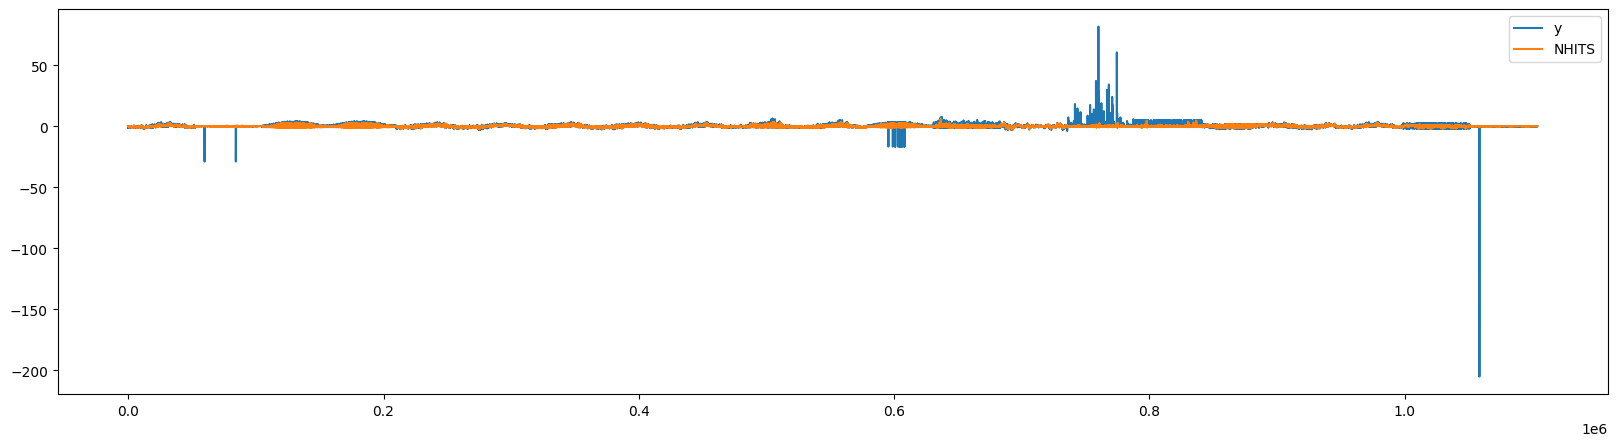

In [15]:
Y_hat_df[['y','NHITS']].plot(figsize=(20, 5))

In [19]:


from neuralforecast.losses.numpy import mae, mse

y_true = Y_hat_df.y.values
y_hat = Y_hat_df["NHITS"].values
n_series = len(Y_hat_df.unique_id.unique())
y_true = y_true.reshape(n_series, -1, horizon)
y_hat = y_hat.reshape(n_series, -1, horizon)
print("\n" * 4)
print("Parsed results")
print(f"NHITS {dataset} h={horizon}")
# print("test_size", test_size)
print("y_true.shape (n_series, n_windows, n_time_out):\t", y_true.shape)
print("y_hat.shape  (n_series, n_windows, n_time_out):\t", y_hat.shape)
# print(' best validation hyperparameter:\t', nf.models[0].results.get_best_result().config)
print("MSE: ", mse(y_hat, y_true))
print("MAE: ", mae(y_hat, y_true))






Parsed results
NHITS Weather h=720
y_true.shape (n_series, n_windows, n_time_out):	 (21, 73, 720)
y_hat.shape  (n_series, n_windows, n_time_out):	 (21, 73, 720)
MSE:  0.54171914
MAE:  0.4132449
